### A Machine learning approach to identify spurious GPS readings



In [1]:
%run "../common.ipynb"

fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?qn=40&type=html";
dfOriginal = LoadDataSet(fileName, columns=None, checkForDateTime=False);

In [2]:
# Prepare dataset
#
# 1. Drop columns we don't need
# 2. Convert column datatypes as needed; to string, datetime, numbers as needed
# 3. Add Calculated Columns
# 4. Filter out rows and reindex the dataframe
# 5. Display the resulting dataframe
# 6. Show some descriptive statistics

#=====
#1. "ProcessedDateId" column is Intentionally misspelled to show it goes undetected if not careful

columns = '''
id, 
stored_at, measured_at, is_valid, api_key, version, record_type, session_num, 
mobile_id, user_id, caller_ip, 
lat, lon, accuracy, speed, bearing, alt, device_temp, device_pressure, device_humidity, device_light, medication, 
weather_time, temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, the_geom, 
location, activity, battery_level, rn"
'''
toDrop= [k.strip() for k in '''id, api_key, version,  session_num, 
mobile_id, 
user_id, 
caller_ip, device_temp, device_pressure, device_humidity, device_light, medication, weather_time, 
temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, 
the_geom,

'''.split(",")]
dfL = dfOriginal.drop(toDrop, axis=1, errors="ignore")

##1a -> Set the Prediction column
##   -> Set class names if you know it or make it None
predictColumn = "is_valid"
class_names = ["Inalid", "Valid"]

##2. Some wrong dates causing error here - so lets treat this as str
dfL[predictColumn] = dfL[predictColumn].astype(str)    # Treat this columns as string
#dfL[u'ProcessedDateId']   = dfL[u'ProcessedDateId'].astype(str)      # Treat this columns as string (intentionally included)


##3. Calculated columns
#dfL[u'DBKLag'] = dfL[u'DBKLag']/60                                   # lets divide this by 60 
#dfL[u'DBKLag'] = dfL.DBKLag.apply(abs)                               # Convert to absolute value 

##4. Filter rows
n1 = dfL.shape[0]
#dfL = dfL[dfL.DBKLag > 1]                                            # Lets take only those that have a value > 0 
#
## Here are other common filtering you may use:
# dfL = dfL[dfL['OEMModel'] == "Surface Pro 4"]
# dfL = dfL[dfL.OSVersionFull.str.contains("th1") | dfL.OSVersionFull.str.contains("th2")]

n2 = dfL.shape[0]
print ("Filtering: Number of rows Before {} and After {}".format(n1,n2));

#4a. You may reshuffle the rows if needed to make sure they are not in any particular order
dfL = dfL.sample(frac=1).reset_index(drop=True)

#4b. 
# Once you filter, it is a good idea to reindex such that 0th row matches to 0th row in the resulting dataframe
# To see what happens if you didn't to reindex, comment out the following code and notice index 1 and 3 are visibly missing 

dfL = dfL.reset_index(drop=True) 

#5.
displayDFs(dfL, showIcons=True, showStats=True, maxrows = 4) 

# You can see the entire dataframe by using the following
# HTML(dfL.to_html())

Filtering: Number of rows Before 84 and After 84


count,84,84,84,84,84.000,84.000,84.000,78.000,78.000,78.000,0.000,84,0.000,84.000
unique,84,82,2,5,-,-,-,-,-,-,0.000,1,0.000,-
top,2015-08-25 17:34:15.714527,2016-03-09 00:27:04.0,1,gps,-,-,-,-,-,-,-,null,-,-
freq,1,2,53,54,-,-,-,-,-,-,-,84,-,-
mean,-,-,-,-,45.048,-100.130,299.742,0.793,21.478,65.128,-,-,-,11227.357
std,-,-,-,-,5.568,58.256,512.418,3.495,57.977,285.801,-,-,-,3991.127
min,-,-,-,-,24.186,-122.322,0.000,0.000,0.000,-10.000,-,-,-,1620.000
25%,-,-,-,-,44.965,-122.143,21.447,0.000,0.000,0.000,-,-,-,9601.000
50%,-,-,-,-,47.643,-122.137,48.287,0.000,0.000,0.000,-,-,-,10871.500
75%,-,-,-,-,47.645,-104.924,406.993,0.000,0.000,0.000,-,-,-,13422.250
max,-,-,-,-,47.654,127.050,2805.000,27.518,319.000,1843.000,-,-,-,20460.000


## Predictions

In [3]:
# Lets convert the columns to numeric 
# Please see Prepare in Features.py 

df =  prepareDF(dfL, makeCopy=True)

# After you run this, this will remove ProcessDateId column since it seems like a key column
# Review the resulting final data set;
#df = df.sample(frac=1).reset_index(drop=True)
df

Dropping in prepareDF -  Index(['stored_at', 'measured_at'], dtype='object')


,is_valid,record_type,lat,lon,accuracy,speed,bearing,alt,location,activity,battery_level,rn
0,1,2,47.643,-122.138,899.999,0.000,0.000,0.000,0,0,0,9652
1,0,4,44.881,-91.931,16.985,0.000,0.000,0.000,0,0,0,7167
2,0,2,47.648,-122.135,800.000,0.000,0.000,0.000,0,0,0,12827
3,0,2,39.564,-104.899,427.973,0.000,0.000,0.000,0,0,0,9452
...,...,...,...,...,...,...,...,...,...,...,...,...
80,1,2,39.519,-104.932,1399.999,0.000,0.000,0.000,0,0,0,9335
81,1,2,39.863,-104.673,45.000,0.000,0.000,0.000,0,0,0,9217
82,0,4,47.645,-122.137,21.192,0.000,0.000,0.000,0,0,0,10695
83,1,2,47.648,-122.137,1200.000,0.000,0.000,0.000,0,0,0,13588


Feature space holds 84 observations and 11 features
Unique target labels: [1 0]
* 0
* 1
* 2
* 3
* 4
*
   DecisionTree Gini accuracy: 0.690476 
             precision    recall  f1-score   support

          0       0.71      0.85      0.78        53
          1       0.62      0.42      0.50        31

avg / total       0.68      0.69      0.67        84


* 0
* 1
* 2
* 3
* 4
*
   DecisionTree Entr accuracy: 0.750000 
             precision    recall  f1-score   support

          0       0.74      0.92      0.82        53
          1       0.78      0.45      0.57        31

avg / total       0.76      0.75      0.73        84


* 0
* 1
* 2
* 3
* 4
*
                 SVM accuracy: 0.619048 
             precision    recall  f1-score   support

          0       0.63      0.94      0.76        53
          1       0.40      0.06      0.11        31

avg / total       0.55      0.62      0.52        84


* 0
* 1
* 2
* 3
* 4
*
                K-NN accuracy: 0.619048 
             precisi

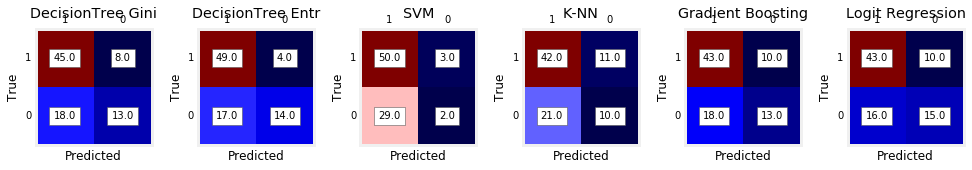

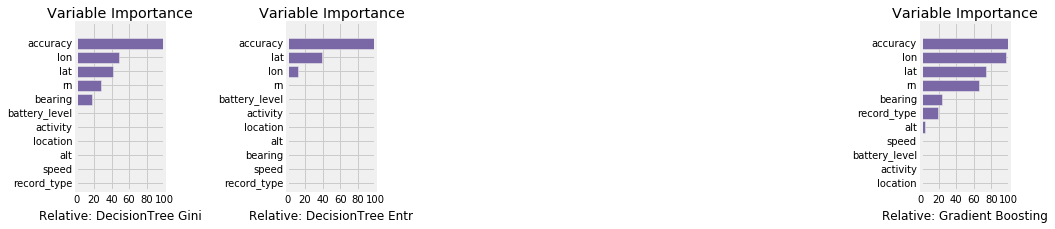

Wall time: 1e+03 ms


In [4]:
%%time
cls = [# Comment/uncomment out any classfiers according to your need 
       # DO NOT CHANGE
        "DecisionTree Gini" , DecisionTreeClassifier(max_depth=4, criterion="gini"), 
        "DecisionTree Entr" , DecisionTreeClassifier(max_depth=4, criterion="entropy"), 
        "SVM"               , sklearn.svm.SVC(), 
        #"Random Forest"     , sklearn.ensemble.RandomForestClassifier(),
        "K-NN"              , sklearn.neighbors.KNeighborsClassifier(),
        "Gradient Boosting" , sklearn.ensemble.RandomForestClassifier(),
        "Logit Regression"  , sklearn.linear_model.LogisticRegression()
];

y = df[predictColumn]
X = df.drop(predictColumn, axis=1)
(X1,y1,ra,cls) = Classify(X,y, True, drawConfusionMatrix=True, classifiers=cls, scale=False)


In [5]:
decisionTrees = []

for k in range(len(cls)/2):
    d = cls[k*2+1];
    if (str(type(d)).find('DecisionTreeClassifier') > 0):
        decisionTrees.append(cls[k*2])
        decisionTrees.append(cls[k*2+1])

d = DrawDecisionTree(X,y, decisionTrees, class_names);

TypeError: 'float' object cannot be interpreted as an integer